# iCAT import
---

#### Overview
The purpose of this notebook is to facilitate and guide in the creation of `render-ws` stacks. These stacks are made up of metadata regarding a collection of image tiles such as the geometric bounds, number of tiles and sections, resolution, etc. Each image tile in a stack has its own respective metadata as well, called a [tile specification](https://render-python.readthedocs.io/en/latest/guide/index.html#making-a-new-stack). Using [`pandas`](https://pandas.pydata.org/) and the [`icatapi`](https://github.com/lanery/iCAT-workflow/tree/master/icatapi), this notebook creates these tile specifications from image metadata, gathers them into stacks, and uploads the stacks to a local `render-ws` server.

#### Naming conventions
Within the context of the iCAT workflow, a collection of images from a single data source (e.g. individual fluorescence channel) is referred to as a "tileset". The collection of multiple data sources across an individual section is referred to as a "layer", while a "stack" is the collection of the same individual data source across multiple sections. A "project" is then a collection of multiple stacks.

-            | 1 section | > 1 section
------------ | --------- | -----------
\> 1 channel | layer     | project (or stacks)
1 channel    | tileset   | stack


#### Heirarchy
When building up `DataFrame`s of tile specifications, it is often necessary to group the data by stack or section. To try to stick to a convention, the sorting order is in general `stack` followed by `z` (or `sectionId`).


#### [TileSpec](https://github.com/fcollman/render-python/blob/master/renderapi/tilespec.py#L17) parameters

| Field    | Type     | Default | Description                                |
| -----    | ----     | ------- | -----------                                |
| tileId   | str      | None    | Unique string specifying a tile's identity |
| z        | float    | None    | z values this tile exists within           |
| width    | int      | None    | Width in pixels of the raw tile            |
| height   | int      | None    | Height in pixels of the raw tile           |
| imageUrl | str      | None    | An image path URI                          |
| maskUrl  | str      | None    | An image path for an alpha mask            |
| minint   | int      | 0       | Pixel intensity value to display as black  |
| maxint   | int      | 65535   | Pixel intensity value to display as white  |
| layout   | `Layout` | None    | a `Layout` object for this tile            |
| tforms   | list     | [ ]     | Transform objects                          |


#### [Layout](https://github.com/fcollman/render-python/blob/master/renderapi/layout.py#L1) parameters

| Field     | Type  | Default | Description                                  |
| -----     | ----  | ------- | -----------                                  |
| sectionId | str   | None    | sectionId this tile was taken from           |
| scopeId   | str   | None    | What microscope this came from               |
| cameraId  | str   | None    | Camera this was taken with                   |
| imageRow  | int   | None    | Row from a row,col layout this was taken     |
| imageCol  | int   | None    | Column from a row,col layout this was taken  |
| stageX    | float | None    | X stage coordinates for where this was taken |
| stageY    | float | None    | Y stage coordinates for where this was taken |
| rotation  | float | None    | Angle of camera when this was taken          |
| pixelsize | float | None    | Effective size of pixels                     |

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from icatapi.importo import parse_metadata

In [3]:
# from pathlib import Path
# from itertools import product
# from pprint import pprint

# from tqdm.notebook import tqdm
# from bs4 import BeautifulSoup as Soup
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import altair as alt

# from shapely.geometry import box
# from shapely import affinity
# import matplotlib.pyplot as plt
# from matplotlib.patches import Polygon
# import matplotlib.ticker as mticker

# from tifffile import TiffFile, imread
# from skimage.exposure import histogram

# import renderapi
# from renderapi.tilespec import TileSpec
# from renderapi.layout import Layout
# from renderapi.transform import AffineModel as AffineRender

# from icatapi.importo import parse_metadata
# from icatapi.render_pandas import *
# from icatapi.render_image import *

#### Settings

In [4]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

# Set matplotlib colormap
plt.set_cmap('magma')
plt.close();

## Set up environment
---

In [5]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = 'zebrafish'

# Data directories
# ----------------
project_dir = Path(f'/long_term_storage/{owner}/SECOM/projects/{project}')
stack_dirs = list(project_dir.glob('[!_]*/[!_]*'))

# Additional parameters
# ---------------------
section_thickness = 100  # nm

# Infer section and stack names
# -----------------------------
sectionIds = np.unique([fp.parent.name for fp in stack_dirs]).tolist()
stacks = np.unique([fp.name for fp in stack_dirs]).tolist()
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

out = f"""\
sections..... {sectionIds}
all stacks... {stacks}
EM stacks.... {stacks_EM}
FM stacks.... {stacks_FM}
"""
print(out)

sections..... ['S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042']
all stacks... ['big_EM', 'hoechst', 'insulin', 'lil_EM']
EM stacks.... ['big_EM', 'lil_EM']
FM stacks.... ['hoechst', 'insulin']



### Create `render-ws` instance

In [6]:
import renderapi

In [7]:
# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'zebrafish',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

### Rotation data
Input rotation angles from the acquisition.

In [8]:
data = {
    35: 12,
    36: 10,
    37: 9,
    38: 11,
    39: 9,
    40: 8,
    41: 5,
    42: 3,
}

df_rot = pd.DataFrame(data, index=['hoechst']).T
df_rot['insulin'] = df_rot['hoechst']
df_rot['big_EM'] = df_rot['hoechst']
df_rot['lil_EM'] = df_rot['hoechst'] + 30
df_rot.head()

hoechst  insulin  big_EM  lil_EM
35       12       12      12      42
36       10       10      10      40
37        9        9       9      39
38       11       11      11      41
39        9        9       9      39

## Build up image tile DataFrame
---

In [9]:
# Collect tile specifications
tile_dicts = []

# Iterate through stack directories
for fp_stack in tqdm(stack_dirs):

    # Set stack and section
    stack = fp_stack.name
    sectionId = fp_stack.parent.name

    # Iterate through tile data
    fps_tiles = list(fp_stack.glob('*.tif'))
    for i, fp_tile in enumerate(fps_tiles):

        # Parse tif file metadata
        tile_dict = parse_metadata(fp_tile, sectionId)

        # Set rotation angle
        z = tile_dict['z']
        try: theta = df_rot.loc[z, stack]
        except KeyError: theta = 0
        tile_dict['rotation'] = theta
        tile_dict['stack'] = stack
        tile_dict['sectionId'] = sectionId
        tile_dicts.append(tile_dict)

# Build DataFrame
df_tiles = pd.DataFrame(tile_dicts)
# Preview
preview_cols = ['z', 'sectionId', 'tileId', 'imageRow', 'imageCol',
                'stageX', 'stageY', 'width', 'height',
                'pixelsize', 'rotation', 'acqTime']
df_tiles.groupby(['stack']).apply(lambda x: x.sample(3))[preview_cols]

  0%|          | 0/32 [00:00<?, ?it/s]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
big_EM  801  41      S041  big_EM-S041-0000...         0         3   
        267  37      S037  big_EM-S037-0000...         0         1   
        931  42      S042  big_EM-S042-0000...         0         0   
hoechst 804  41      S041  hoechst-S041-000...         0         2   
        539  39      S039  hoechst-S039-000...         0         3   
        802  41      S041  hoechst-S041-000...         0         0   
insulin 142  36      S036  insulin-S036-000...         0         1   
        674  40      S040  insulin-S040-000...         0         1   
        542  39      S039  insulin-S039-000...         0         2   
lil_EM  398  37      S037  lil_EM-S037-0001...        10        10   
        912  41      S041  lil_EM-S041-0000...         3         9   
        613  39      S039  lil_EM-S039-0000...         2         7   

                  stageX       stageY  width  height   pixelsize  rotation  \
stack                                                                        
big_EM  801 -6225.435000  5219.799000   4096    4096   20.883413         5   
        267 -4969.824000  1037.758000   4096    4096   20.883413         9   
        931 -6737.448000  5006.570000   4096    4096   20.883413         3   
hoechst 804 -6390.491000  5234.500000   2048    2048  110.599890         5   
        539 -6163.672632  5701.242363   2048    2048  110.143262         9   
        802 -6720.508000  5263.777000   2048    2048  110.599890         5   
insulin 142 -4934.415638  1293.550533   2048    2048  109.874495        10   
        674 -6528.672618  5497.026738   2048    2048  110.240464         8   
        542 -6330.012217  5727.557234   2048    2048  110.179788         9   
lil_EM  398 -1906.475000 -7983.140000   4096    4096    4.913448        39   
        912 -3419.713000 -3675.592000   4096    4096    4.913448        35   
        613 -3361.062000 -3128.822000   4096    4096    4.913448        39   

                        acqTime  
stack                            
big_EM  801 2021-03-30 15:29:12  
        267 2021-03-30 11:30:00  
        931 2021-03-30 15:39:06  
hoechst 804 2021-03-30 15:26:44  
        539 2021-03-30 15:04:56  
        802 2021-03-30 15:22:30  
insulin 142 2021-03-30 10:39:43  
        674 2021-03-30 15:12:46  
        542 2021-03-30 15:03:00  
lil_EM  398 2021-04-16 13:19:16  
        912 2021-04-19 11:43:14  
        613 2021-04-19 08:54:18

### Image tile count

In [10]:
import altair as alt

In [11]:
# Make tile count DataFrame for plotting / display purposes
df_tilecount = df_tiles.loc[:, ['sectionId', 'stack', 'z']]
bars = alt.Chart(df_tilecount).mark_bar().encode(
    x='count()',
    y='stack:N',
    color='stack:N',
)

text = bars.mark_text(
    align='left',
    baseline='middle'
).encode(
    text='count()'
)

alt.layer(bars, text, data=df_tilecount).properties(
    width=200,
    height=150,
).facet(
    column='sectionId:N'
)

alt.FacetChart(...)

## Refine image tile DataFrame
---

### `tileId` - add alphanumeric prefix
This is because `render-ws` renders tiles alphanumerically. So we add an alphabetic prefix to tile names so that newer tiles appear on top.

In [12]:
from itertools import product

In [13]:
def gen_prefix(n=3):
    """Generates a sequence of length `n` characters in alphabetical order
    e.g. for n=3 [aaa, aab, aac, ..., zzx, zzy, zzz]
    """
    n = min(n, 4)
    characters = 'abcdefghijklmnopqrstuvwxyz'
    for s in product(characters, repeat=n):
        yield ''.join(s)

In [14]:
# Group by tileset
tilesets = []
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):
    
    # Sort by acquisition time such that top entry is last acquired
    tileset = tileset.sort_values('acqTime', ascending=False)\
                     .reset_index(drop=True).copy()
    
    # Prepend alphanumeric prefix to each tileId
    prefixes = pd.Series(gen_prefix())[:len(tileset)]
    tileset['tileId'] = prefixes + '_' + tileset['tileId']
    tilesets.append(tileset)
    
# Update image tile DataFrame
df_tiles = pd.concat(tilesets).reset_index(drop=True)
# Preview
df_tiles.groupby(['stack']).apply(lambda x: x.head(3))[preview_cols]

z sectionId               tileId  imageRow  imageCol  \
stack                                                               
big_EM  0   35      S035  aaa_big_EM-S035-...         0         3   
        1   35      S035  aab_big_EM-S035-...         0         2   
        2   35      S035  aac_big_EM-S035-...         0         1   
hoechst 32  35      S035  aaa_hoechst-S035...         0         3   
        33  35      S035  aab_hoechst-S035...         0         2   
        34  35      S035  aac_hoechst-S035...         0         1   
insulin 64  35      S035  aaa_insulin-S035...         0         3   
        65  35      S035  aab_insulin-S035...         0         2   
        66  35      S035  aac_insulin-S035...         0         1   
lil_EM  96  35      S035  aaa_lil_EM-S035-...        10        10   
        97  35      S035  aab_lil_EM-S035-...        10         9   
        98  35      S035  aac_lil_EM-S035-...        10         8   

                 stageX       stageY  width  height   pixelsize  rotation  \
stack                                                                       
big_EM  0  -4486.956000  1510.203000   4096    4096   20.883413        12   
        1  -4649.423000  1542.236000   4096    4096   20.883413        12   
        2  -4811.765000  1574.384000   4096    4096   20.883413        12   
hoechst 32 -4485.887121  1510.991426   2048    2048  109.842819        12   
        33 -4648.958968  1542.965941   2048    2048  109.882813        12   
        34 -4812.220224  1574.861510   2048    2048  109.867821        12   
insulin 64 -4485.867121  1510.995426   2048    2048  109.842819        12   
        65 -4648.966968  1542.930941   2048    2048  109.882813        12   
        66 -4811.948224  1574.863510   2048    2048  109.867821        12   
lil_EM  96 -1729.592000 -7450.908000   4096    4096    4.913448        42   
        97 -1741.736000 -7437.944000   4096    4096    4.913448        42   
        98 -1753.790000 -7425.076000   4096    4096    4.913448        42   

                       acqTime  
stack                           
big_EM  0  2021-03-30 10:33:01  
        1  2021-03-30 10:30:55  
        2  2021-03-30 10:28:49  
hoechst 32 2021-03-30 10:32:40  
        33 2021-03-30 10:30:34  
        34 2021-03-30 10:28:27  
insulin 64 2021-03-30 10:32:51  
        65 2021-03-30 10:30:45  
        66 2021-03-30 10:28:38  
lil_EM  96 2021-04-15 18:18:13  
        97 2021-04-15 18:17:37  
        98 2021-04-15 18:17:01

### `tforms` - set affine transformations
Place image tiles in `render` coordinate space (aka pixel space) such that top left image tile is at ~(0, 0) and its width and height are simply its width and height in pixels. Translation is derived from converting the stage position (`stageX`, `stageY`) into pixel space by dividing by the pixel size. But first, visualize the layout of each tileset.

#### Map out tilesets

In [15]:
import seaborn as sns
from shapely.geometry import box
from shapely import affinity
from matplotlib.patches import Polygon

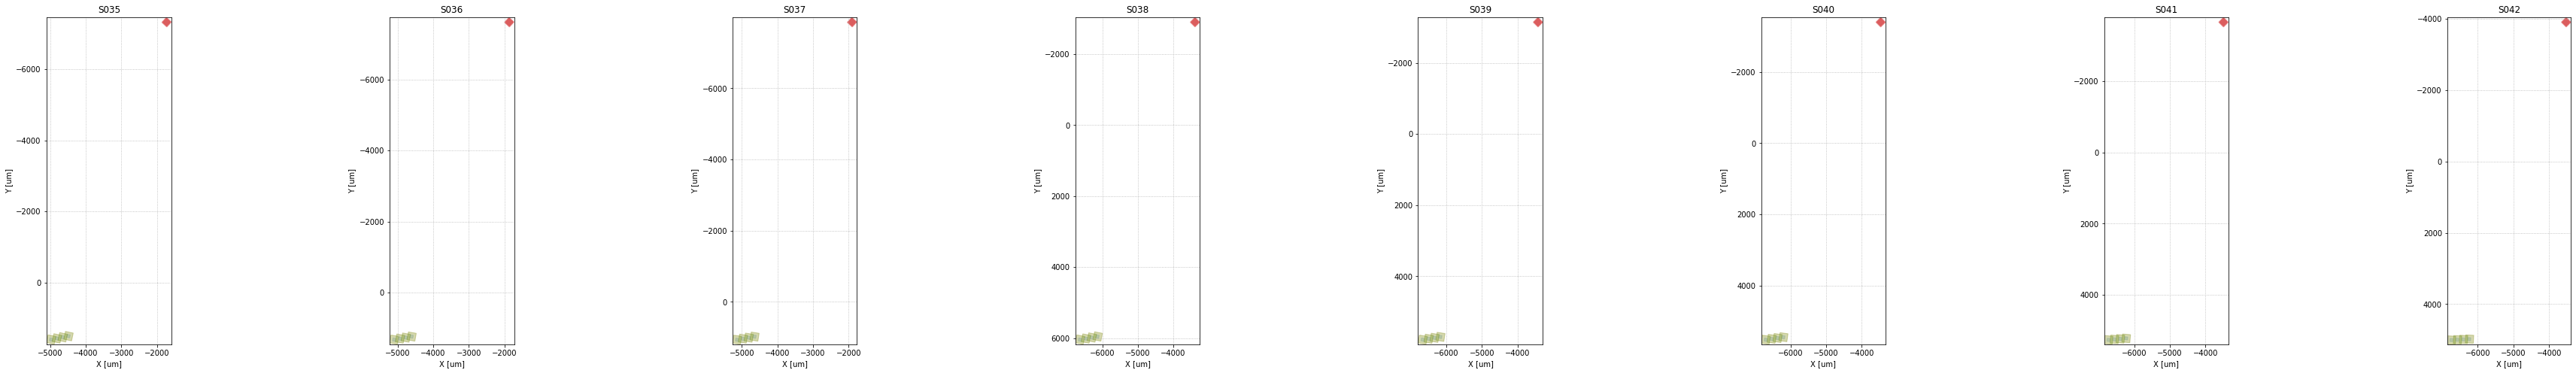

In [16]:
# Set up figure
# -------------
ncols = len(sectionIds)
fig, axes = plt.subplots(ncols=ncols, squeeze=False,
                         figsize=(8*ncols, 8))
axmap = {k: v for k, v in zip(sectionIds, axes.flat)}
cmap = {k: v for k, v in zip(stacks, sns.color_palette(n_colors=len(stacks)))}

# Iterate through layers
for sectionId, layer in df_tiles.groupby('sectionId'):
    # Collect all tiles in each layer to determine bounds
    boxes = []
    # Set axis
    ax = axmap[sectionId]

    # Loop through tilesets within each layer
    for stack, tileset in layer.groupby('stack'):

        # Loop through each tile
        for i, tile in tileset.iterrows():

            # Create `shapely.box`
            dx = tile['width']/2 * tile['pixelsize']/1e3
            dy = tile['height']/2 * tile['pixelsize']/1e3
            minx, maxx = (tile['stageX'] - dx, tile['stageX'] + dx)
            miny, maxy = (tile['stageY'] - dy, tile['stageY'] + dy)
            b = box(minx, miny, maxx, maxy)
            b = affinity.rotate(b, tile['rotation'])
            boxes.append(b)
            # Get coordinates of `shapely.box` to plot matplotlib polygon patch
            xy = np.array(b.exterior.xy).T
            p = Polygon(xy, color=cmap[stack], alpha=0.2)
            ax.add_patch(p)

    # Axis aesthetics
    ax.set_title(sectionId)
    ax.set_xlabel('X [um]')
    ax.set_ylabel('Y [um]')
    # Determine bounds
    bounds = np.swapaxes([b.exterior.xy for b in boxes], 1, 2).reshape(-1, 2)
    ax.set_xlim(bounds[:, 0].min(), bounds[:, 0].max())
    ax.set_ylim(bounds[:, 1].min(), bounds[:, 1].max())
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.grid(ls=':')

#### Apply translations

In [17]:
from renderapi.transform import AffineModel

In [18]:
# Iterate through tilesets
for (stack, z), tileset in df_tiles.groupby(['stack', 'z']):

    # Offset by stage position
    # ------------------------
    # Normalize to (0, 0) since Odemis stage position is basically random
    x0 = tileset['stageX'] - tileset['stageX'].min()
    y0 = tileset['stageY'] - tileset['stageY'].min()
    # Divide by pixelsize and flip y axis
    x0 =  x0 / (tileset['pixelsize']/1e3)  # um / (um/px) = px
    y0 = -y0 / (tileset['pixelsize']/1e3)  # um / (um/px) = px
    # Shift y translation up so that it's all positivo
    y0 -= y0.min()

    # Calculate rotation angle
    # ------------------------
    M00s =  np.cos(np.deg2rad(tileset['rotation']))
    M01s = -np.sin(np.deg2rad(tileset['rotation']))
    M10s =  np.sin(np.deg2rad(tileset['rotation']))
    M11s =  np.cos(np.deg2rad(tileset['rotation']))

    # Add `render` affine transformations to DataFrame
    # ------------------------------------------------
    # Generate `render` affine transform
    A = [[AffineModel(M00, M01, M10, M11, x, y)] for \
                      M00, M01, M10, M11, x, y in zip(M00s, M01s, M10s, M11s, x0, y0)]
    # Add to DataFrame
    for j, (i, tile) in enumerate(tileset.iterrows()):
        df_tiles.loc[i, 'tforms'] = [A[j]]

# Preview
df_tiles.groupby('stack').apply(lambda x: x.sample(3))[preview_cols + ['tforms']]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
big_EM  2    35      S035  aac_big_EM-S035-...         0         1   
        22   40      S040  aac_big_EM-S040-...         0         1   
        30   42      S042  aac_big_EM-S042-...         0         1   
hoechst 63   42      S042  aad_hoechst-S042...         0         0   
        36   36      S036  aaa_hoechst-S036...         0         3   
        60   42      S042  aaa_hoechst-S042...         0         3   
insulin 94   42      S042  aac_insulin-S042...         0         1   
        74   37      S037  aac_insulin-S037...         0         1   
        76   38      S038  aaa_insulin-S038...         0         3   
lil_EM  963  42      S042  aau_lil_EM-S042-...         9         9   
        999  42      S042  ace_lil_EM-S042-...         5         1   
        666  39      S039  adi_lil_EM-S039-...         3         9   

                  stageX       stageY  width  height   pixelsize  rotation  \
stack                                                                        
big_EM  2   -4811.765000  1574.384000   4096    4096   20.883413        12   
        22  -6530.275000  5498.250000   4096    4096   20.883413         8   
        30  -6571.050000  4997.848000   4096    4096   20.883413         3   
hoechst 63  -6734.537199  5006.491148   2048    2048  110.223685         3   
        36  -4607.045430  1235.532639   2048    2048  109.841856        10   
        60  -6230.078119  4980.069415   2048    2048  110.220962         3   
insulin 94  -6566.348702  4997.723775   2048    2048  110.223926         3   
        74  -4968.642556  1036.393539   2048    2048  109.877294         9   
        76  -6127.343970  5952.718813   2048    2048  110.122092        11   
lil_EM  963 -3522.212000 -4002.346000   4096    4096    4.913448        33   
        999 -3572.412000 -3851.886000   4096    4096    4.913448        33   
        666 -3348.025000 -3166.880000   4096    4096    4.913448        39   

                        acqTime               tforms  
stack                                                 
big_EM  2   2021-03-30 10:28:49  [M=[[0.978148,-0...  
        22  2021-03-30 15:12:56  [M=[[0.990268,-0...  
        30  2021-03-30 15:41:13  [M=[[0.998630,-0...  
hoechst 63  2021-03-30 15:38:44  [M=[[0.998630,-0...  
        36  2021-03-30 10:43:45  [M=[[0.984808,-0...  
        60  2021-03-30 15:45:05  [M=[[0.998630,-0...  
insulin 94  2021-03-30 15:41:02  [M=[[0.998630,-0...  
        74  2021-03-30 11:29:50  [M=[[0.987688,-0...  
        76  2021-03-30 14:53:43  [M=[[0.981627,-0...  
lil_EM  963 2021-04-19 14:07:17  [M=[[0.838671,-0...  
        999 2021-04-19 13:45:48  [M=[[0.838671,-0...  
        666 2021-04-19 08:57:18  [M=[[0.777146,-0...

### `minint`, `maxint` - set min, max intensity levels 

#### FM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

In [19]:
from tifffile import imread
from skimage import exposure
import matplotlib.ticker as mticker

In [20]:
# Parameters
# ----------
N = 10     # Sample size
pct1 = 30  # min %ile
pct2 = 99  # max %ile

# Set up figure
ncols=len(sectionIds)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         squeeze=False, figsize=(ncols*5, 4))

# Loop through FM stacks
total = len(stacks_FM) * len(sectionIds)
axmap = {k: v for k, v in zip(sectionIds, axes.flat)}
cmap = {k: v for k, v in zip(stacks_FM, sns.color_palette(n_colors=len(stacks_FM)))}
for i, ((stack, sectionId), tileset) in tqdm(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_FM)]\
                                                             .groupby(['stack', 'sectionId'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('://')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = exposure.histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['sectionId'] == sectionId),
                 ['minint', 'maxint']] = int(p1), 2*int(p1)

    # Plot
    ax = axmap[sectionId]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    ax.fill_between(bin_centers, 0, hist, color=color, alpha=0.1)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(sectionId)
    ax.set_xscale('symlog', base=2)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend()
    ax.grid(ls=':')

  0%|          | 0/16 [00:00<?, ?it/s]

#### EM channels
Sample `N` FM image tiles (per section), take histogram and assign min, max intensity levels according to min and max percentile specified

  0%|          | 0/16 [00:00<?, ?it/s]

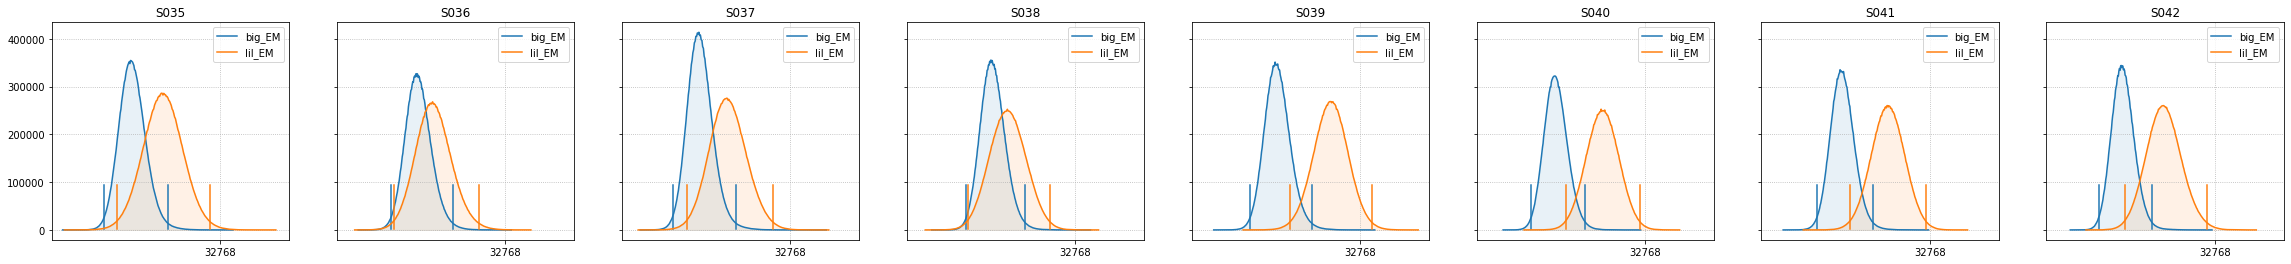

In [21]:
# Parameters
# ----------
N = 5     # Sample size
pct1 = 1   # min %ile
pct2 = 99  # max %ile

# Set up figure
ncols=len(sectionIds)
fig, axes = plt.subplots(ncols=ncols, sharex=True, sharey=True,
                         squeeze=False, figsize=(ncols*5, 4))

# Loop through EM stacks
total = len(stacks_EM) * len(sectionIds)
axmap = {k: v for k, v in zip(sectionIds, axes.flat)}
cmap = {k: v for k, v in zip(stacks_EM, sns.color_palette(n_colors=len(stacks_EM)))}
for i, ((stack, sectionId), tileset) in tqdm(enumerate(df_tiles.loc[df_tiles['stack'].isin(stacks_EM)]\
                                                               .groupby(['stack', 'sectionId'])), total=total):
    # Choose random sample
    fps = tileset.sample(n=min(N, len(tileset)))['imageUrl']

    # Loop through sample image tiles
    images = []
    for fp in fps:

        # Accumulate images
        image = imread(fp.split('://')[1])
        images.append(image)

    # Take histograms
    mean = np.mean(images, axis=0)
    hist, bin_centers = exposure.histogram(mean)
    p1, p2 = np.percentile(mean, (pct1, pct2))

    # Set min, max intensity
    df_tiles.loc[(df_tiles['stack'] == stack) &\
                 (df_tiles['sectionId'] == sectionId),
                 ['minint', 'maxint']] = int(p1), int(p2)

    # Plot
    ax = axmap[sectionId]
    color = cmap[stack]
    ax.plot(bin_centers, hist, color=color, label=stack)
    ax.fill_between(bin_centers, 0, hist, color=color, alpha=0.1)
    [ax.axvline(p, ymin=0.05, ymax=0.25, color=color) for p in [p1, p2]]
    # Aesthetics
    ax.set_title(sectionId)
    ax.set_xscale('symlog', base=2)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend()
    ax.grid(ls=':')

#### Optionally overwrite min, max intensity levels

In [22]:
# ranges = {
#     'insulin': (3000, 4000),
#     'hoechst': (1500, 2500),
#     'big_EM': (31900, 33450),
#     'lil_EM': (29800, 33000)
# }

# # Specify stack and sectionId(s)
# sectionIds_ = sectionIds

# df_tiles.loc[(df_tiles['stack'] == 'lil_EM') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['lil_EM']

# df_tiles.loc[(df_tiles['stack'] == 'big_EM') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['big_EM']

# df_tiles.loc[(df_tiles['stack'] == 'hoechst') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['hoechst']

# df_tiles.loc[(df_tiles['stack'] == 'insulin') &\
#              (df_tiles['sectionId'].isin(sectionIds_)),
#              ['minint', 'maxint']] = ranges['insulin']

In [23]:
# Preview
df_tiles.groupby('stack').apply(lambda x: x.sample(3))[preview_cols + ['minint', 'maxint']]

z sectionId               tileId  imageRow  imageCol  \
stack                                                                
big_EM  29   42      S042  aab_big_EM-S042-...         0         2   
        3    35      S035  aad_big_EM-S035-...         0         0   
        5    36      S036  aab_big_EM-S036-...         0         2   
hoechst 49   39      S039  aab_hoechst-S039...         0         2   
        51   39      S039  aad_hoechst-S039...         0         0   
        38   36      S036  aac_hoechst-S036...         0         1   
insulin 76   38      S038  aaa_insulin-S038...         0         3   
        82   39      S039  aac_insulin-S039...         0         1   
        71   36      S036  aad_insulin-S036...         0         0   
lil_EM  928  41      S041  aec_lil_EM-S041-...         1         7   
        419  37      S037  add_lil_EM-S037-...         3         4   
        396  37      S037  acg_lil_EM-S037-...         5         3   

                  stageX       stageY  width  height   pixelsize  rotation  \
stack                                                                        
big_EM  29  -6404.589000  4989.088000   4096    4096   20.883413         3   
        3   -4974.240000  1606.451000   4096    4096   20.883413        12   
        5   -4771.294000  1264.385000   4096    4096   20.883413        10   
hoechst 49  -6330.043217  5727.570234   2048    2048  110.179788         9   
        51  -6663.255567  5780.219466   2048    2048  110.182179         9   
        38  -4934.402638  1293.538533   2048    2048  109.874495        10   
insulin 76  -6127.343970  5952.718813   2048    2048  110.122092        11   
        82  -6496.662370  5753.878648   2048    2048  110.186286         9   
        71  -5097.721974  1322.472036   2048    2048  109.866408        10   
lil_EM  928 -3419.739000 -3625.658000   4096    4096    4.913448        35   
        419 -1887.823000 -7821.333000   4096    4096    4.913448        39   
        396 -1925.900000 -7832.687000   4096    4096    4.913448        39   

                        acqTime  minint  maxint  
stack                                            
big_EM  29  2021-03-30 15:43:19   29613   31031  
        3   2021-03-30 10:26:43   29610   31303  
        5   2021-03-30 10:42:00   29648   31303  
hoechst 49  2021-03-30 15:02:49    7554   15108  
        51  2021-03-30 14:58:35    7554   15108  
        38  2021-03-30 10:39:32    8440   16880  
insulin 76  2021-03-30 14:53:43    4320    8640  
        82  2021-03-30 15:00:54    4290    8580  
        71  2021-03-30 10:37:37    4383    8766  
lil_EM  928 2021-04-19 11:31:18   30547   32657  
        419 2021-04-16 12:30:49   29935   32277  
        396 2021-04-16 12:44:35   29935   32277

## Import image tiles to `render-ws`
---

### Create stacks

In [24]:
from icatapi.render_pandas import create_stack_from_DataFrame

In [25]:
# Loop through stacks
for stack, df_stack in tqdm(df_tiles.groupby('stack')):

    # Set stack resolution
    Rx = df_stack['pixelsize'].iloc[0]
    Ry = df_stack['pixelsize'].iloc[0]
    Rz = section_thickness

    # Create stacks
    create_stack_from_DataFrame(df=df_stack,
                                name=stack,
                                stackResolutionX=Rx,
                                stackResolutionY=Ry,
                                stackResolutionZ=Rz,
                                render=render)

  0%|          | 0/4 [00:00<?, ?it/s]

Creating tile specifications for big_EM...
Importing tile specifications to big_EM...
Stack big_EM created successfully.
Creating tile specifications for hoechst...
Importing tile specifications to hoechst...
Stack hoechst created successfully.
Creating tile specifications for insulin...
Importing tile specifications to insulin...
Stack insulin created successfully.
Creating tile specifications for lil_EM...
Importing tile specifications to lil_EM...
Stack lil_EM created successfully.


## Inspect stacks
---

In [33]:
from icatapi.render_pandas import create_stacks_DataFrame
from icatapi.render_image import plot_tile_map, plot_neighborhoods, plot_stacks

### Create project DataFrame

In [34]:
# Project DataFrame
stacks_2_plot = ['big_EM', 'hoechst', 'insulin', 'lil_EM']
df_project = create_stacks_DataFrame(stacks=stacks_2_plot,
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))

tileId     z   width  height   minint   maxint  \
stack                                                                      
big_EM  5    aab_big_EM-S036-...  36.0  4096.0  4096.0  29648.0  31303.0   
        20   aaa_big_EM-S040-...  40.0  4096.0  4096.0  29663.0  31105.0   
        13   aab_big_EM-S038-...  38.0  4096.0  4096.0  29803.0  31358.0   
hoechst 34   aac_hoechst-S035...  35.0  2048.0  2048.0   7761.0  15522.0   
        41   aab_hoechst-S037...  37.0  2048.0  2048.0   8518.0  17036.0   
        53   aab_hoechst-S040...  40.0  2048.0  2048.0   7810.0  15620.0   
insulin 79   aad_insulin-S038...  38.0  2048.0  2048.0   4320.0   8640.0   
        67   aad_insulin-S035...  35.0  2048.0  2048.0   4388.0   8776.0   
        69   aab_insulin-S036...  36.0  2048.0  2048.0   4383.0   8766.0   
lil_EM  732  abf_lil_EM-S040-...  40.0  4096.0  4096.0  30572.0  32622.0   
        370  abg_lil_EM-S037-...  37.0  4096.0  4096.0  29935.0  32277.0   
        846  aay_lil_EM-S041-...  41.0  4096.0  4096.0  30547.0  32657.0   

                        imageUrl               tforms    stack sectionId  \
stack                                                                      
big_EM  5    file:///long_ter...  [M=[[0.984808,-0...   big_EM      S036   
        20   file:///long_ter...  [M=[[0.990268,-0...   big_EM      S040   
        13   file:///long_ter...  [M=[[0.981627,-0...   big_EM      S038   
hoechst 34   file:///long_ter...  [M=[[0.978148,-0...  hoechst      S035   
        41   file:///long_ter...  [M=[[0.987688,-0...  hoechst      S037   
        53   file:///long_ter...  [M=[[0.990268,-0...  hoechst      S040   
insulin 79   file:///long_ter...  [M=[[0.981627,-0...  insulin      S038   
        67   file:///long_ter...  [M=[[0.978148,-0...  insulin      S035   
        69   file:///long_ter...  [M=[[0.984808,-0...  insulin      S036   
lil_EM  732  file:///long_ter...  [M=[[0.788011,-0...   lil_EM      S040   
        370  file:///long_ter...  [M=[[0.777146,-0...   lil_EM      S037   
        846  file:///long_ter...  [M=[[0.819152,-0...   lil_EM      S041   

             imageRow  imageCol       stageX       stageY  rotation  
stack                                                                
big_EM  5           0         2 -4771.294000  1264.385000      10.0  
        20          0         3 -6202.306000  5451.476000       8.0  
        13          0         2 -6299.253000  5984.021000      11.0  
hoechst 34          0         1 -4812.220224  1574.861510      12.0  
        41          0         2 -4804.959686  1007.505712       9.0  
        53          0         2 -6362.583726  5473.539535       8.0  
insulin 79          0         0 -6625.611880  6040.535976      11.0  
        67          0         0 -4974.690946  1606.685177      12.0  
        69          0         2 -4770.769062  1264.571690      10.0  
lil_EM  732         8         1 -3553.900000 -3383.589000      38.0  
        370         8         0 -2000.830000 -7829.521000      39.0  
        846         8         8 -3495.535000 -3725.048000      35.0

### Map out tiles in `render` space

  0%|          | 0/8 [00:00<?, ?it/s]

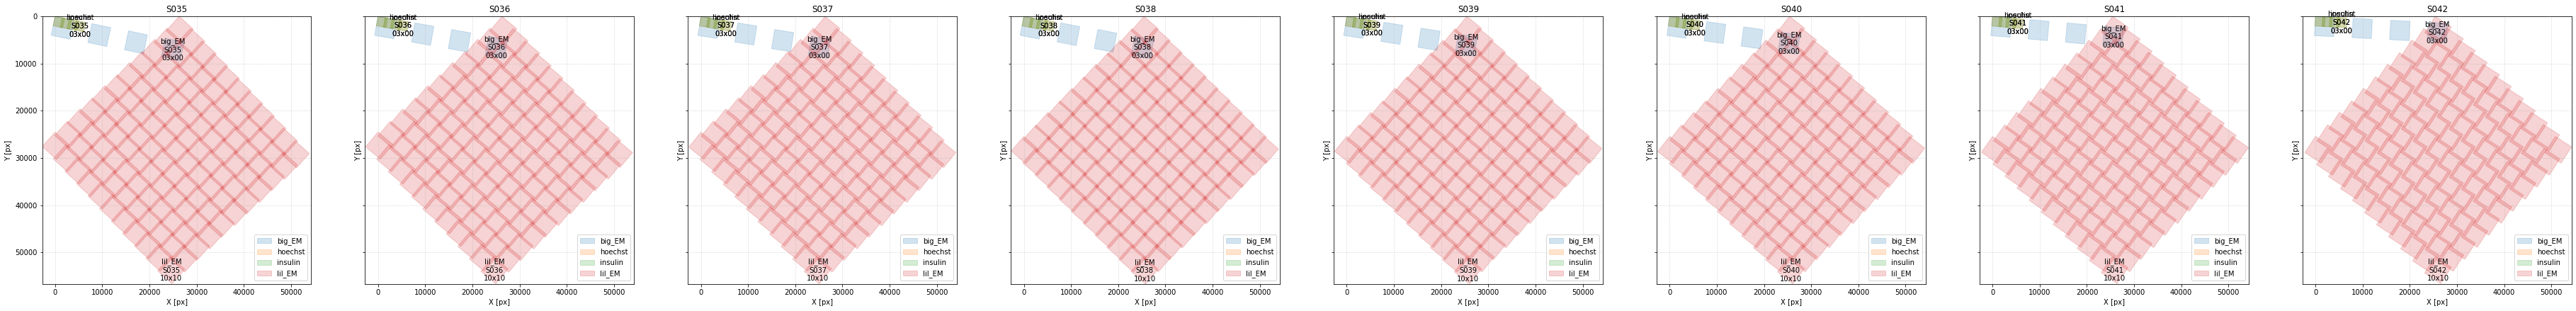

In [35]:
# Plot tile map
plot_tile_map(stacks_2_plot, render=render)

### Render images

#### Sample tile images

  0%|          | 0/32 [00:00<?, ?it/s]

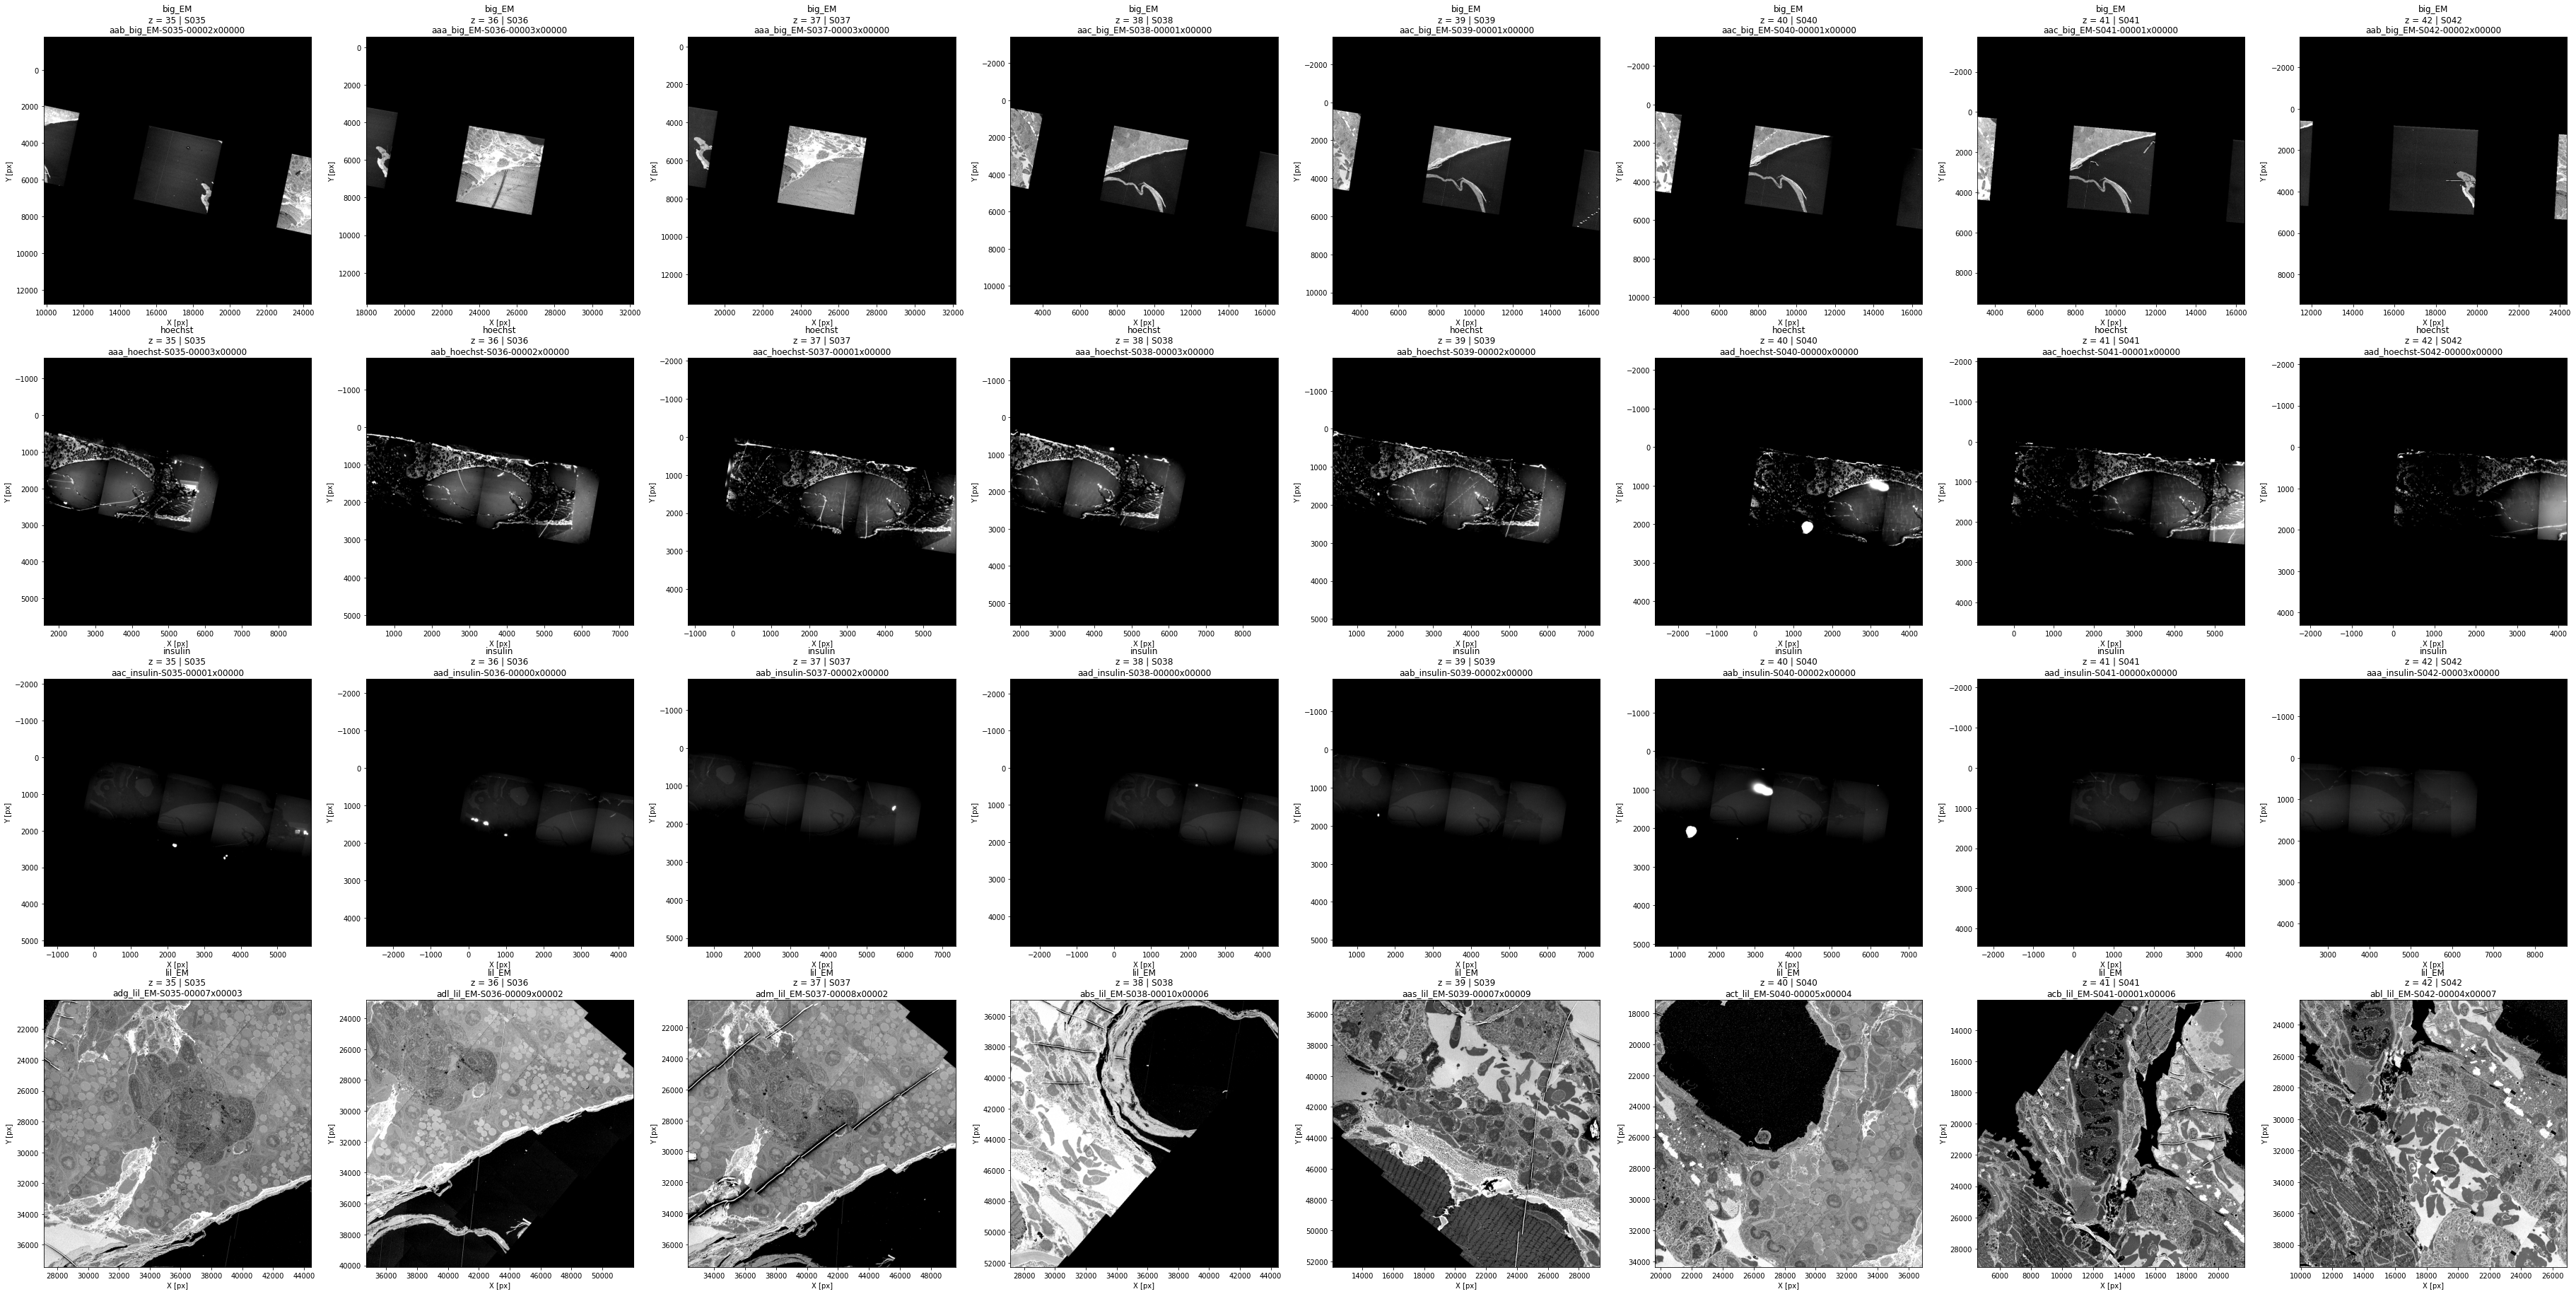

In [36]:
plot_neighborhoods(stacks=stacks_2_plot,
                   render=render)

#### Tileset images

  0%|          | 0/32 [00:00<?, ?it/s]

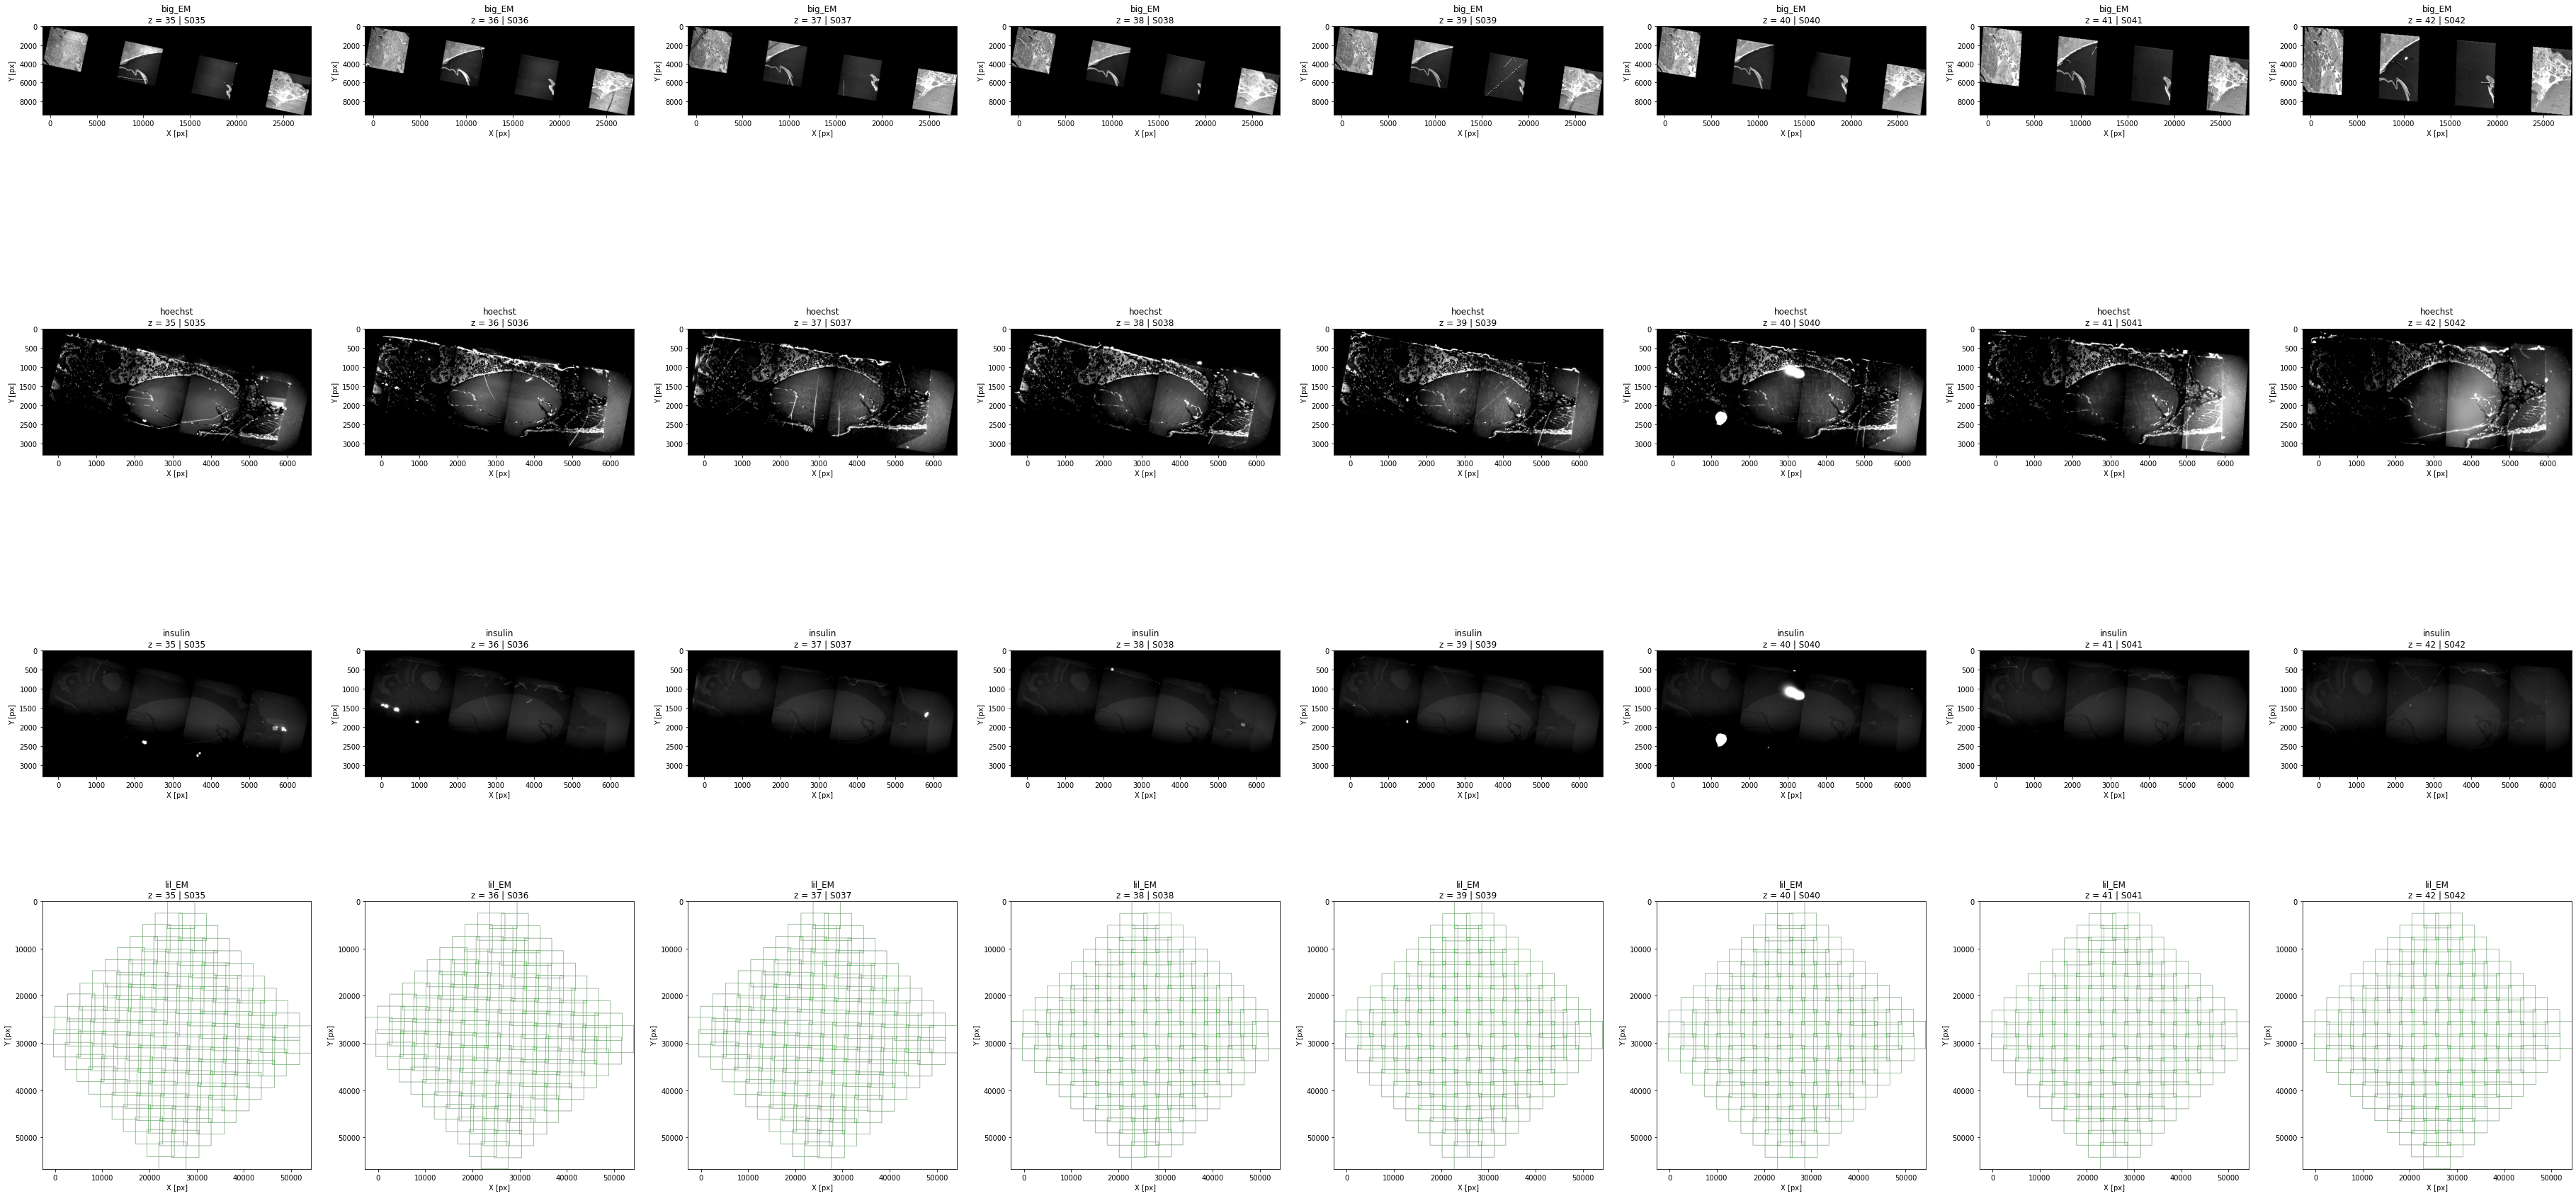

In [37]:
plot_stacks(stacks=stacks_2_plot,
            maxTileSpecsToRender=30,
            render=render)